<a href="https://colab.research.google.com/github/LalithaMunukutla/Click-through-rate-prediction/blob/main/CTR_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from copy import copy
from itertools import chain
from collections import (namedtuple, OrderedDict,defaultdict)
from tensorflow.python.layers import utils
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.backend import batch_dot
from tensorflow.python.keras.initializers import (Zeros, glorot_normal,glorot_uniform, TruncatedNormal, RandomNormal)
from tensorflow.python.keras.layers import (Layer,Input,Flatten,Embedding,Lambda,LSTM)
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class NoMask(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(NoMask, self).__init__(**kwargs)

    def build(self, input_shape):
        super(NoMask, self).build(input_shape)

    def call(self, x, mask=None, **kwargs):
        return x

    def compute_mask(self, inputs, mask):
        return None

class Hash(tf.keras.layers.Layer):

    def __init__(self, num_buckets, mask_zero=False, **kwargs):
        self.num_buckets = num_buckets
        self.mask_zero = mask_zero
        super(Hash, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Hash, self).build(input_shape)

    def call(self, x, mask=None, **kwargs):
        if x.dtype != tf.string:
            zero = tf.as_string(tf.zeros([1], dtype=x.dtype))
            x = tf.as_string(x, )
        else:
            zero = tf.as_string(tf.zeros([1], dtype='int32'))
        num_buckets = self.num_buckets if not self.mask_zero else self.num_buckets - 1
        try:
            hash_x = tf.string_to_hash_bucket_fast(x, num_buckets,name=None)
        except:
            hash_x = tf.strings.to_hash_bucket_fast(x, num_buckets,name=None)
        if self.mask_zero:
            mask = tf.cast(tf.not_equal(x, zero), dtype='int64')
            hash_x = (hash_x + 1) * mask

        return hash_x
    def get_config(self, ):
        config = {'num_buckets': self.num_buckets, 'mask_zero': self.mask_zero, }
        base_config = super(Hash, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class Linear(tf.keras.layers.Layer):

    def __init__(self, l2_reg=0.0, mode=0, use_bias=False, seed=1024, **kwargs):
        self.l2_reg = l2_reg
        if mode not in [0, 1, 2]:
            raise ValueError("mode must be 0,1 or 2")
        self.mode = mode
        self.use_bias = use_bias
        self.seed = seed
        super(Linear, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.use_bias:
            self.bias = self.add_weight(name='linear_bias',shape=(1,),initializer=tf.keras.initializers.Zeros(),trainable=True)
        if self.mode == 1:
            self.kernel = self.add_weight('linear_kernel',shape=[int(input_shape[-1]), 1],initializer=tf.keras.initializers.glorot_normal(self.seed),regularizer=tf.keras.regularizers.l2(self.l2_reg),trainable=True)
        elif self.mode == 2:
            self.kernel = self.add_weight('linear_kernel',shape=[int(input_shape[1][-1]), 1],initializer=tf.keras.initializers.glorot_normal(self.seed),regularizer=tf.keras.regularizers.l2(self.l2_reg),trainable=True)
        super(Linear, self).build(input_shape)

    def call(self, inputs, **kwargs):
        if self.mode == 0:
            sparse_input = inputs
            linear_logit = reduce_sum(sparse_input, axis=-1, keep_dims=True)
        elif self.mode == 1:
            dense_input = inputs
            fc = tf.tensordot(dense_input, self.kernel, axes=(-1, 0))
            linear_logit = fc
        else:
            sparse_input, dense_input = inputs
            fc = tf.tensordot(dense_input, self.kernel, axes=(-1, 0))
            linear_logit = reduce_sum(sparse_input, axis=-1, keep_dims=False) + fc
        if self.use_bias:
            linear_logit += self.bias
        return linear_logit

    def compute_output_shape(self, input_shape):
        return (None, 1)

    def compute_mask(self, inputs, mask):
        return None

    def get_config(self, ):
        config = {'mode': self.mode, 'l2_reg': self.l2_reg, 'use_bias': self.use_bias, 'seed': self.seed}
        base_config = super(Linear, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def concat_func(inputs, axis=-1, mask=False):
    if not mask:
        inputs = list(map(NoMask(), inputs))
    if len(inputs) == 1:
        return inputs[0]
    else:
        return tf.keras.layers.Concatenate(axis=axis)(inputs)

def reduce_sum(input_tensor,axis=None,keep_dims=False, name=None, reduction_indices=None):
    try:
        return tf.reduce_sum(input_tensor,axis=axis,keep_dims=keep_dims,name=name, reduction_indices=reduction_indices)
    except TypeError:
        return tf.reduce_sum(input_tensor,axis=axis,keepdims=keep_dims,name=name)

def reduce_max(input_tensor,axis=None,keep_dims=False,name=None,reduction_indices=None):
    try:
        return tf.reduce_max(input_tensor,axis=axis,keep_dims=keep_dims,name=name,reduction_indices=reduction_indices)
    except TypeError:
        return tf.reduce_max(input_tensor,axis=axis,keepdims=keep_dims,name=name)

def div(x, y, name=None):
    try:
        return tf.div(x, y, name=name)
    except AttributeError:
        return tf.divide(x, y, name=name)

def softmax(logits, dim=-1, name=None):
    try:
        return tf.nn.softmax(logits, dim=dim, name=name)
    except TypeError:
        return tf.nn.softmax(logits, axis=dim, name=name)


class Add(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Add, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Add, self).build(input_shape)

    def call(self, inputs, **kwargs):
        if not isinstance(inputs, list):
            return inputs
        if len(inputs) == 1:
            return inputs[0]
        if len(inputs) == 0:
            return tf.constant([[0.0]])
        return tf.keras.layers.add(inputs)


def add_func(inputs):
    return Add()(inputs)


def combined_dnn_input(sparse_embedding_list, dense_value_list):
    if len(sparse_embedding_list) > 0 and len(dense_value_list) > 0:
        sparse_dnn_input = Flatten()(concat_func(sparse_embedding_list))
        dense_dnn_input = Flatten()(concat_func(dense_value_list))
        return concat_func([sparse_dnn_input, dense_dnn_input])
    elif len(sparse_embedding_list) > 0:
        return Flatten()(concat_func(sparse_embedding_list))
    elif len(dense_value_list) > 0:
        return Flatten()(concat_func(dense_value_list))
    else:
        raise NotImplementedError("dnn_feature_columns can not be empty list")

In [ ]:
try:
    unicode
except NameError:
    unicode = str

class Dice(Layer):

    def __init__(self, axis=-1, epsilon=1e-9, **kwargs):
        self.axis = axis
        self.epsilon = epsilon
        super(Dice, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bn = tf.keras.layers.BatchNormalization(axis=self.axis, epsilon=self.epsilon, center=False, scale=False)
        self.alphas = self.add_weight(shape=(input_shape[-1],), initializer=Zeros( ), dtype=tf.float32, name='dice_alpha')
        super(Dice, self).build(input_shape)
        self.uses_learning_phase = True

    def call(self, inputs, training=None, **kwargs):
        inputs_normed = self.bn(inputs, training=training)
        x_p = tf.sigmoid(inputs_normed)
        return self.alphas * (1.0 - x_p) * inputs + x_p * inputs

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self, ):
        config = {'axis': self.axis, 'epsilon': self.epsilon}
        base_config = super(Dice, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def activation_layer(activation):
    if activation in ("dice", "Dice"):
        act_layer = Dice()
    elif isinstance(activation, (str, unicode)):
        act_layer = tf.keras.layers.Activation(activation)
    elif issubclass(activation, Layer):
        act_layer = activation()
    else:
        raise ValueError("Invalid activation,found %s.You should use a str or a Activation Layer Class." % (activation))
    return act_layer

In [ ]:
class DNN(Layer):

    def __init__(self, hidden_units, activation='relu', l2_reg=0, dropout_rate=0, use_bn=False, output_activation=None,seed=1024, **kwargs):
        self.hidden_units = hidden_units
        self.activation = activation
        self.l2_reg = l2_reg
        self.dropout_rate = dropout_rate
        self.use_bn = use_bn
        self.output_activation = output_activation
        self.seed = seed
        super(DNN, self).__init__(**kwargs)

    def build(self, input_shape):
        input_size = input_shape[-1]
        hidden_units = [int(input_size)] + list(self.hidden_units)
        self.kernels = [self.add_weight(name='kernel' + str(i),shape=(hidden_units[i], hidden_units[i + 1]),initializer=glorot_normal(seed=self.seed),regularizer=l2(self.l2_reg),trainable=True) for i in range(len(self.hidden_units))]
        self.bias = [self.add_weight(name='bias' + str(i),shape=(self.hidden_units[i],),initializer=Zeros(),trainable=True) for i in range(len(self.hidden_units))]
        if self.use_bn:
            self.bn_layers = [tf.keras.layers.BatchNormalization() for _ in range(len(self.hidden_units))]
        self.dropout_layers = [tf.keras.layers.Dropout(self.dropout_rate, seed=self.seed + i) for i in range(len(self.hidden_units))]
        self.activation_layers = [activation_layer(self.activation) for _ in range(len(self.hidden_units))]
        if self.output_activation:
            self.activation_layers[-1] = activation_layer(self.output_activation)
        super(DNN, self).build(input_shape)

    def call(self, inputs, training=None, **kwargs):
        deep_input = inputs
        for i in range(len(self.hidden_units)):
            fc = tf.nn.bias_add(tf.tensordot(deep_input, self.kernels[i], axes=(-1, 0)), self.bias[i])
            if self.use_bn:
                fc = self.bn_layers[i](fc, training=training)
            fc = self.activation_layers[i](fc)
            fc = self.dropout_layers[i](fc, training=training)
            deep_input = fc
        return deep_input

    def compute_output_shape(self, input_shape):
        if len(self.hidden_units) > 0:
            shape = input_shape[:-1] + (self.hidden_units[-1],)
        else:
            shape = input_shape
        return tuple(shape)

    def get_config(self, ):
        config = {'activation': self.activation, 'hidden_units': self.hidden_units,'l2_reg': self.l2_reg, 'use_bn': self.use_bn, 'dropout_rate': self.dropout_rate,'output_activation': self.output_activation, 'seed': self.seed}
        base_config = super(DNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class PredictionLayer(Layer):

    def __init__(self, task='binary', use_bias=True, **kwargs):
        if task not in ["binary", "multiclass", "regression"]:
            raise ValueError("task must be binary,multiclass or regression")
        self.task = task
        self.use_bias = use_bias
        super(PredictionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.use_bias:
            self.global_bias = self.add_weight(shape=(1,), initializer=Zeros(), name="global_bias")
        super(PredictionLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs
        if self.use_bias:
            x = tf.nn.bias_add(x, self.global_bias, data_format='NHWC')
        if self.task == "binary":
            x = tf.sigmoid(x)
        output = tf.reshape(x, (-1, 1))
        return output

    def compute_output_shape(self, input_shape):
        return (None, 1)

    def get_config(self, ):
        config = {'task': self.task, 'use_bias': self.use_bias}
        base_config = super(PredictionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
DEFAULT_GROUP_NAME = "default_group"
class SparseFeat(namedtuple('SparseFeat',['name', 'vocabulary_size', 'embedding_dim', 'use_hash', 'dtype', 'embeddings_initializer','embedding_name','group_name', 'trainable'])):
    __slots__ = ()
    def __new__(cls, name, vocabulary_size, embedding_dim=4, use_hash=False, dtype="int32", embeddings_initializer=None,embedding_name=None,group_name=DEFAULT_GROUP_NAME, trainable=True):
        if embedding_dim == "auto":
            embedding_dim = 6 * int(pow(vocabulary_size, 0.25))
        if embeddings_initializer is None:
            embeddings_initializer = RandomNormal(mean=0.0, stddev=0.0001, seed=2020)
        if embedding_name is None:
            embedding_name = name
        return super(SparseFeat, cls).__new__(cls, name, vocabulary_size, embedding_dim, use_hash, dtype,embeddings_initializer,embedding_name, group_name, trainable)

    def __hash__(self):
        return self.name.__hash__()

class VarLenSparseFeat(namedtuple('VarLenSparseFeat',['sparsefeat', 'maxlen', 'combiner', 'length_name', 'weight_name', 'weight_norm'])):
    __slots__ = ()
    def __new__(cls, sparsefeat, maxlen, combiner="mean", length_name=None, weight_name=None, weight_norm=True):
        return super(VarLenSparseFeat, cls).__new__(cls, sparsefeat, maxlen, combiner, length_name, weight_name,weight_norm)

    @property
    def name(self):
        return self.sparsefeat.name

    @property
    def vocabulary_size(self):
        return self.sparsefeat.vocabulary_size

    @property
    def embedding_dim(self):
        return self.sparsefeat.embedding_dim

    @property
    def use_hash(self):
        return self.sparsefeat.use_hash

    @property
    def dtype(self):
        return self.sparsefeat.dtype

    @property
    def embeddings_initializer(self):
        return self.sparsefeat.embeddings_initializer

    @property
    def embedding_name(self):
        return self.sparsefeat.embedding_name

    @property
    def group_name(self):
        return self.sparsefeat.group_name

    @property
    def trainable(self):
        return self.sparsefeat.trainable

    def __hash__(self):
        return self.name.__hash__()

class DenseFeat(namedtuple('DenseFeat', ['name', 'dimension', 'dtype', 'transform_fn'])):
    __slots__ = ()
    def __new__(cls, name, dimension=1, dtype="float32", transform_fn=None):
        return super(DenseFeat, cls).__new__(cls, name, dimension, dtype, transform_fn)

    def __hash__(self):
        return self.name.__hash__()

def get_feature_names(feature_columns):
    features = build_input_features(feature_columns)
    return list(features.keys())

def build_input_features(feature_columns, prefix=''):
    input_features = OrderedDict()
    for fc in feature_columns:
        if isinstance(fc, SparseFeat):
            input_features[fc.name] = Input(shape=(1,), name=prefix + fc.name, dtype=fc.dtype)
        elif isinstance(fc, DenseFeat):
            input_features[fc.name] = Input(shape=(fc.dimension,), name=prefix + fc.name, dtype=fc.dtype)
        elif isinstance(fc, VarLenSparseFeat):
            input_features[fc.name] = Input(shape=(fc.maxlen,), name=prefix + fc.name,dtype=fc.dtype)
            if fc.weight_name is not None:
                input_features[fc.weight_name] = Input(shape=(fc.maxlen, 1), name=prefix + fc.weight_name,dtype="float32")
            if fc.length_name is not None:
                input_features[fc.length_name] = Input((1,), name=prefix + fc.length_name, dtype='int32')
        else:
            raise TypeError("Invalid feature column type,got", type(fc))
    return input_features

def get_linear_logit(features, feature_columns, units=1, use_bias=False, seed=1024, prefix='linear',l2_reg=0):
    linear_feature_columns = copy(feature_columns)
    for i in range(len(linear_feature_columns)):
        if isinstance(linear_feature_columns[i], SparseFeat):
            linear_feature_columns[i] = linear_feature_columns[i]._replace(embedding_dim=1,embeddings_initializer=Zeros())
        if isinstance(linear_feature_columns[i], VarLenSparseFeat):
            linear_feature_columns[i] = linear_feature_columns[i]._replace(sparsefeat=linear_feature_columns[i].sparsefeat._replace(embedding_dim=1,embeddings_initializer=Zeros()))
    linear_emb_list = [input_from_feature_columns(features, linear_feature_columns, l2_reg, seed,prefix=prefix + str(i))[0] for i in range(units)]
    _, dense_input_list = input_from_feature_columns(features, linear_feature_columns, l2_reg, seed, prefix=prefix)
    linear_logit_list = []
    for i in range(units):
        if len(linear_emb_list[i]) > 0 and len(dense_input_list) > 0:
            sparse_input = concat_func(linear_emb_list[i])
            dense_input = concat_func(dense_input_list)
            linear_logit = Linear(l2_reg, mode=2, use_bias=use_bias, seed=seed)([sparse_input, dense_input])
        elif len(linear_emb_list[i]) > 0:
            sparse_input = concat_func(linear_emb_list[i])
            linear_logit = Linear(l2_reg, mode=0, use_bias=use_bias, seed=seed)(sparse_input)
        elif len(dense_input_list) > 0:
            dense_input = concat_func(dense_input_list)
            linear_logit = Linear(l2_reg, mode=1, use_bias=use_bias, seed=seed)(dense_input)
        else:
            return add_func([])
        linear_logit_list.append(linear_logit)
    return concat_func(linear_logit_list)

def input_from_feature_columns(features, feature_columns, l2_reg, seed, prefix='', seq_mask_zero=True,support_dense=True, support_group=False):
    sparse_feature_columns = list(filter(lambda x: isinstance(x, SparseFeat), feature_columns)) if feature_columns else []
    varlen_sparse_feature_columns = list(filter(lambda x: isinstance(x, VarLenSparseFeat), feature_columns)) if feature_columns else []
    embedding_matrix_dict = create_embedding_matrix(feature_columns, l2_reg, seed, prefix=prefix,seq_mask_zero=seq_mask_zero)
    group_sparse_embedding_dict = embedding_lookup(embedding_matrix_dict, features, sparse_feature_columns)
    dense_value_list = get_dense_input(features, feature_columns)
    if not support_dense and len(dense_value_list) > 0:
        raise ValueError("DenseFeat is not supported in dnn_feature_columns")
    sequence_embed_dict = varlen_embedding_lookup(embedding_matrix_dict, features, varlen_sparse_feature_columns)
    group_varlen_sparse_embedding_dict = get_varlen_pooling_list(sequence_embed_dict, features,varlen_sparse_feature_columns)
    group_embedding_dict = mergeDict(group_sparse_embedding_dict, group_varlen_sparse_embedding_dict)
    if not support_group:
        group_embedding_dict = list(chain.from_iterable(group_embedding_dict.values()))
    return group_embedding_dict, dense_value_list

In [ ]:
def get_inputs_list(inputs):
    return list(chain(*list(map(lambda x: x.values(), filter(lambda x: x is not None, inputs)))))

def create_embedding_dict(sparse_feature_columns, varlen_sparse_feature_columns, seed, l2_reg,prefix='sparse_', seq_mask_zero=True):
    sparse_embedding = {}
    for feat in sparse_feature_columns:
        emb = Embedding(feat.vocabulary_size, feat.embedding_dim,embeddings_initializer=feat.embeddings_initializer,embeddings_regularizer=l2(l2_reg),name=prefix + '_emb_' + feat.embedding_name)
        emb.trainable = feat.trainable
        sparse_embedding[feat.embedding_name] = emb
    if varlen_sparse_feature_columns and len(varlen_sparse_feature_columns) > 0:
        for feat in varlen_sparse_feature_columns:
            emb = Embedding(feat.vocabulary_size, feat.embedding_dim,embeddings_initializer=feat.embeddings_initializer, embeddings_regularizer=l2(l2_reg),name=prefix + '_seq_emb_' + feat.name,mask_zero=seq_mask_zero)
            emb.trainable = feat.trainable
            sparse_embedding[feat.embedding_name] = emb
    return sparse_embedding

def get_embedding_vec_list(embedding_dict, input_dict, sparse_feature_columns, return_feat_list=(), mask_feat_list=()):
    embedding_vec_list = []
    for fg in sparse_feature_columns:
        feat_name = fg.name
        if len(return_feat_list) == 0 or feat_name in return_feat_list:
            if fg.use_hash:
                lookup_idx = Hash(fg.vocabulary_size, mask_zero=(feat_name in mask_feat_list))(input_dict[feat_name])
            else:
                lookup_idx = input_dict[feat_name]
            embedding_vec_list.append(embedding_dict[feat_name](lookup_idx))
    return embedding_vec_list

def create_embedding_matrix(feature_columns, l2_reg, seed, prefix="", seq_mask_zero=True):
    sparse_feature_columns = list(filter(lambda x: isinstance(x, SparseFeat), feature_columns)) if feature_columns else []
    varlen_sparse_feature_columns = list(filter(lambda x: isinstance(x, VarLenSparseFeat), feature_columns)) if feature_columns else []
    sparse_emb_dict = create_embedding_dict(sparse_feature_columns, varlen_sparse_feature_columns, seed,l2_reg, prefix=prefix + 'sparse', seq_mask_zero=seq_mask_zero)
    return sparse_emb_dict

def embedding_lookup(sparse_embedding_dict, sparse_input_dict, sparse_feature_columns, return_feat_list=(),mask_feat_list=(), to_list=False):
    group_embedding_dict = defaultdict(list)
    for fc in sparse_feature_columns:
        feature_name = fc.name
        embedding_name = fc.embedding_name
        if (len(return_feat_list) == 0 or feature_name in return_feat_list):
            if fc.use_hash:
                lookup_idx = Hash(fc.vocabulary_size, mask_zero=(feature_name in mask_feat_list))(sparse_input_dict[feature_name])
            else:
                lookup_idx = sparse_input_dict[feature_name]
            group_embedding_dict[fc.group_name].append(sparse_embedding_dict[embedding_name](lookup_idx))
    if to_list:
        return list(chain.from_iterable(group_embedding_dict.values()))
    return group_embedding_dict

def varlen_embedding_lookup(embedding_dict, sequence_input_dict, varlen_sparse_feature_columns):
    varlen_embedding_vec_dict = {}
    for fc in varlen_sparse_feature_columns:
        feature_name = fc.name
        embedding_name = fc.embedding_name
        if fc.use_hash:
            lookup_idx = Hash(fc.vocabulary_size, mask_zero=True)(sequence_input_dict[feature_name])
        else:
            lookup_idx = sequence_input_dict[feature_name]
        varlen_embedding_vec_dict[feature_name] = embedding_dict[embedding_name](lookup_idx)
    return varlen_embedding_vec_dict

def get_varlen_pooling_list(embedding_dict, features, varlen_sparse_feature_columns, to_list=False):
    pooling_vec_list = defaultdict(list)
    for fc in varlen_sparse_feature_columns:
        feature_name = fc.name
        combiner = fc.combiner
        feature_length_name = fc.length_name
        if feature_length_name is not None:
            if fc.weight_name is not None:
                seq_input = WeightedSequenceLayer(weight_normalization=fc.weight_norm)([embedding_dict[feature_name], features[feature_length_name], features[fc.weight_name]])
            else:
                seq_input = embedding_dict[feature_name]
            vec = SequencePoolingLayer(combiner, supports_masking=False)([seq_input, features[feature_length_name]])
        else:
            if fc.weight_name is not None:
                seq_input = WeightedSequenceLayer(weight_normalization=fc.weight_norm, supports_masking=True)([embedding_dict[feature_name], features[fc.weight_name]])
            else:
                seq_input = embedding_dict[feature_name]
                vec = SequencePoolingLayer(combiner, supports_masking=True)(seq_input)
        pooling_vec_list[fc.group_name].append(vec)
    if to_list:
        return chain.from_iterable(pooling_vec_list.values())
    return pooling_vec_list

def get_dense_input(features, feature_columns):
    dense_feature_columns = list(filter(lambda x: isinstance(x, DenseFeat), feature_columns)) if feature_columns else []
    dense_input_list = []
    for fc in dense_feature_columns:
        if fc.transform_fn is None:
            dense_input_list.append(features[fc.name])
        else:
            transform_result = Lambda(fc.transform_fn)(features[fc.name])
            dense_input_list.append(transform_result)
    return dense_input_list

def mergeDict(a, b):
    c = defaultdict(list)
    for k, v in a.items():
        c[k].extend(v)
    for k, v in b.items():
        c[k].extend(v)
    return c

In [ ]:
class SequencePoolingLayer(Layer):

    def __init__(self, mode='mean', supports_masking=False, **kwargs):
        if mode not in ['sum', 'mean', 'max']:
            raise ValueError("mode must be sum or mean")
        self.mode = mode
        self.eps = tf.constant(1e-8, tf.float32)
        super(SequencePoolingLayer, self).__init__(**kwargs)
        self.supports_masking = supports_masking

    def build(self, input_shape):
        if not self.supports_masking:
            self.seq_len_max = int(input_shape[0][1])
        super(SequencePoolingLayer, self).build(input_shape)

    def call(self, seq_value_len_list, mask=None, **kwargs):
        if self.supports_masking:
            if mask is None:
                raise ValueError("When supports_masking=True,input must support masking")
            uiseq_embed_list = seq_value_len_list
            mask = tf.cast(mask, tf.float32)  # tf.to_float(mask)
            user_behavior_length = reduce_sum(mask, axis=-1, keep_dims=True)
            mask = tf.expand_dims(mask, axis=2)
        else:
            uiseq_embed_list, user_behavior_length = seq_value_len_list
            mask = tf.sequence_mask(user_behavior_length,self.seq_len_max, dtype=tf.float32)
            mask = tf.transpose(mask, (0, 2, 1))
        embedding_size = uiseq_embed_list.shape[-1]
        mask = tf.tile(mask, [1, 1, embedding_size])
        if self.mode == "max":
            hist = uiseq_embed_list - (1 - mask) * 1e9
            return reduce_max(hist, 1, keep_dims=True)
        hist = reduce_sum(uiseq_embed_list * mask, 1, keep_dims=False)
        if self.mode == "mean":
            hist = div(hist, tf.cast(user_behavior_length, tf.float32) + self.eps)
        hist = tf.expand_dims(hist, axis=1)
        return hist

    def compute_output_shape(self, input_shape):
        if self.supports_masking:
            return (None, 1, input_shape[-1])
        else:
            return (None, 1, input_shape[0][-1])

    def compute_mask(self, inputs, mask):
        return None

    def get_config(self, ):
        config = {'mode': self.mode, 'supports_masking': self.supports_masking}
        base_config = super(SequencePoolingLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class WeightedSequenceLayer(Layer):

    def __init__(self, weight_normalization=True, supports_masking=False, **kwargs):
        super(WeightedSequenceLayer, self).__init__(**kwargs)
        self.weight_normalization = weight_normalization
        self.supports_masking = supports_masking

    def build(self, input_shape):
        if not self.supports_masking:
            self.seq_len_max = int(input_shape[0][1])
        super(WeightedSequenceLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, input_list, mask=None, **kwargs):
        if self.supports_masking:
            if mask is None:
                raise ValueError("When supports_masking=True,input must support masking")
            key_input, value_input = input_list
            mask = tf.expand_dims(mask[0], axis=2)
        else:
            key_input, key_length_input, value_input = input_list
            mask = tf.sequence_mask(key_length_input,self.seq_len_max, dtype=tf.bool)
            mask = tf.transpose(mask, (0, 2, 1))
        embedding_size = key_input.shape[-1]
        if self.weight_normalization:
            paddings = tf.ones_like(value_input) * (-2 ** 32 + 1)
        else:
            paddings = tf.zeros_like(value_input)
        value_input = tf.where(mask, value_input, paddings)
        if self.weight_normalization:
            value_input = softmax(value_input, dim=1)
        if len(value_input.shape) == 2:
            value_input = tf.expand_dims(value_input, axis=2)
            value_input = tf.tile(value_input, [1, 1, embedding_size])
        return tf.multiply(key_input, value_input)

    def compute_output_shape(self, input_shape):
        return input_shape[0]

    def compute_mask(self, inputs, mask):
        if self.supports_masking:
            return mask[0]
        else:
            return None

    def get_config(self, ):
        config = {'weight_normalization': self.weight_normalization, 'supports_masking': self.supports_masking}
        base_config = super(WeightedSequenceLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
class CIN(Layer):

    def __init__(self, layer_size=(128, 128), activation='relu', split_half=True, l2_reg=1e-5, seed=1024, **kwargs):
        if len(layer_size) == 0:
            raise ValueError("layer_size must be a list(tuple) of length greater than 1")
        self.layer_size = layer_size
        self.split_half = split_half
        self.activation = activation
        self.l2_reg = l2_reg
        self.seed = seed
        super(CIN, self).__init__(**kwargs)

    def build(self, input_shape):
        if len(input_shape) != 3:
            raise ValueError("Unexpected inputs dimensions %d, expect to be 3 dimensions" % (len(input_shape)))
        self.field_nums = [int(input_shape[1])]
        self.filters = []
        self.bias = []
        for i, size in enumerate(self.layer_size):
            self.filters.append(self.add_weight(name='filter' + str(i), shape=[1, self.field_nums[-1] * self.field_nums[0], size], dtype=tf.float32, initializer=glorot_uniform(seed=self.seed + i),regularizer=l2(self.l2_reg)))
            self.bias.append(self.add_weight(name='bias' + str(i), shape=[size], dtype=tf.float32,initializer=tf.keras.initializers.Zeros()))
            if self.split_half:
                if i != len(self.layer_size) - 1 and size % 2 > 0:
                    raise ValueError("layer_size must be even number except for the last layer when split_half=True")
                self.field_nums.append(size // 2)
            else:
                self.field_nums.append(size)
        self.activation_layers = [activation_layer(self.activation) for _ in self.layer_size]
        super(CIN, self).build(input_shape)

    def call(self, inputs, **kwargs):
        if K.ndim(inputs) != 3:
            raise ValueError("Unexpected inputs dimensions %d, expect to be 3 dimensions" % (K.ndim(inputs)))
        dim = int(inputs.get_shape()[-1])
        hidden_nn_layers = [inputs]
        final_result = []
        split_tensor0 = tf.split(hidden_nn_layers[0], dim * [1], 2)
        for idx, layer_size in enumerate(self.layer_size):
            split_tensor = tf.split(hidden_nn_layers[-1], dim * [1], 2)
            dot_result_m = tf.matmul(split_tensor0, split_tensor, transpose_b=True)
            dot_result_o = tf.reshape(dot_result_m, shape=[dim, -1, self.field_nums[0] * self.field_nums[idx]])
            dot_result = tf.transpose(dot_result_o, perm=[1, 0, 2])
            curr_out = tf.nn.conv1d(dot_result, filters=self.filters[idx], stride=1, padding='VALID')
            curr_out = tf.nn.bias_add(curr_out, self.bias[idx])
            curr_out = self.activation_layers[idx](curr_out)
            curr_out = tf.transpose(curr_out, perm=[0, 2, 1])
            if self.split_half:
                if idx != len(self.layer_size) - 1:
                    next_hidden, direct_connect = tf.split(curr_out, 2 * [layer_size // 2], 1)
                else:
                    direct_connect = curr_out
                    next_hidden = 0
            else:
                direct_connect = curr_out
                next_hidden = curr_out
            final_result.append(direct_connect)
            hidden_nn_layers.append(next_hidden)
        result = tf.concat(final_result, axis=1)
        result = reduce_sum(result, -1, keep_dims=False)
        return result

    def compute_output_shape(self, input_shape):
        if self.split_half:
            featuremap_num = sum(
                self.layer_size[:-1]) // 2 + self.layer_size[-1]
        else:
            featuremap_num = sum(self.layer_size)
        return (None, featuremap_num)

    def get_config(self, ):
        config = {'layer_size': self.layer_size, 'split_half': self.split_half, 'activation': self.activation,'seed': self.seed}
        base_config = super(CIN, self).get_config()
        base_config.update(config)
        return base_config

class FM(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FM, self).__init__(**kwargs)

    def build(self, input_shape):
        if len(input_shape) != 3:
            raise ValueError("Unexpected inputs dimensions % d,\expect to be 3 dimensions" % (len(input_shape)))
        super(FM, self).build(input_shape)

    def call(self, inputs, **kwargs):
        if K.ndim(inputs) != 3:
            raise ValueError("Unexpected inputs dimensions %d, expect to be 3 dimensions" % (K.ndim(inputs)))
        concated_embeds_value = inputs
        square_of_sum = tf.square(reduce_sum(concated_embeds_value, axis=1, keep_dims=True))
        sum_of_square = reduce_sum(concated_embeds_value * concated_embeds_value, axis=1, keep_dims=True)
        cross_term = square_of_sum - sum_of_square
        cross_term = 0.5 * reduce_sum(cross_term, axis=2, keep_dims=False)
        return cross_term

    def compute_output_shape(self, input_shape):
        return (None, 1)

In [ ]:
def DeepFM(linear_feature_columns, dnn_feature_columns, fm_group=[DEFAULT_GROUP_NAME], dnn_hidden_units=(128, 128),
           l2_reg_linear=0.00001, l2_reg_embedding=0.00001, l2_reg_dnn=0, seed=1024, dnn_dropout=0,
           dnn_activation='relu', dnn_use_bn=False, task='binary'):
    features = build_input_features(linear_feature_columns + dnn_feature_columns)
    inputs_list = list(features.values())
    linear_logit = get_linear_logit(features, linear_feature_columns, seed=seed, prefix='linear',l2_reg=l2_reg_linear)
    group_embedding_dict, dense_value_list = input_from_feature_columns(features, dnn_feature_columns, l2_reg_embedding,seed, support_group=True)
    fm_logit = add_func([FM()(concat_func(v, axis=1))for k, v in group_embedding_dict.items() if k in fm_group])
    dnn_input = combined_dnn_input(list(chain.from_iterable(group_embedding_dict.values())), dense_value_list)
    dnn_output = DNN(dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed)(dnn_input)
    dnn_logit = tf.keras.layers.Dense(1, use_bias=False, kernel_initializer=tf.keras.initializers.glorot_normal(seed=seed))(dnn_output)
    final_logit = add_func([linear_logit, fm_logit, dnn_logit])
    output = PredictionLayer(task)(final_logit)
    model = tf.keras.models.Model(inputs=inputs_list, outputs=output)
    return model

In [ ]:
def DeepFMchanged(linear_feature_columns, dnn_feature_columns, dnn_hidden_units,cin_layer_size, cin_split_half, cin_activation, l2_reg_linear,l2_reg_embedding, l2_reg_dnn, l2_reg_cin, seed, dnn_dropout,dnn_activation, dnn_use_bn, task):
    features = build_input_features(linear_feature_columns + dnn_feature_columns)
    inputs_list = list(features.values())
    linear_logit = get_linear_logit(features, linear_feature_columns, seed=seed, prefix='linear',l2_reg=l2_reg_linear)
    sparse_embedding_list, dense_value_list = input_from_feature_columns(features, dnn_feature_columns,l2_reg_embedding, seed)
    fm_input = concat_func(sparse_embedding_list, axis=1)
    dnn_input = combined_dnn_input(sparse_embedding_list, dense_value_list)
    dnn_output = DNN(dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed)(dnn_input)
    dnn_logit = tf.keras.layers.Dense(1, use_bias=False, kernel_initializer=tf.keras.initializers.glorot_normal(seed))(dnn_output)
    final_logit = add_func([linear_logit, dnn_logit])
    if len(cin_layer_size) > 0:
        exFM_out = CIN(cin_layer_size, cin_activation,cin_split_half, l2_reg_cin, seed)(fm_input)
        exFM_logit = tf.keras.layers.Dense(1, kernel_initializer=tf.keras.initializers.glorot_normal(seed))(exFM_out)
        final_logit = add_func([final_logit, exFM_logit])
    output = PredictionLayer(task)(final_logit)
    model = tf.keras.models.Model(inputs=inputs_list, outputs=output)
    return model

In [ ]:
def split(x):
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

if __name__ == "__main__":
    data = pd.read_csv("./movielens_sample.txt")
    sparse_features = ["movie_id", "user_id","gender", "age", "occupation", "zip", ]
    target = ['rating']
    for feat in sparse_features:
        lbe = LabelEncoder()
        data[feat] = lbe.fit_transform(data[feat])
    key2index = {}
    genres_list = list(map(split, data['genres'].values))
    genres_length = np.array(list(map(len, genres_list)))
    max_len = max(genres_length)
    genres_list = pad_sequences(genres_list, maxlen=max_len, padding='post', )
    fixlen_feature_columns = [SparseFeat(feat, data[feat].max() + 1,embedding_dim=4) for feat in sparse_features]
    use_weighted_sequence = False
    if use_weighted_sequence:
        varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres',vocabulary_size=len(key2index) + 1,embedding_dim=4), maxlen= max_len, combiner='mean',weight_name='genres_weight')]
    else:
        varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres',vocabulary_size= len(key2index) + 1,embedding_dim=4), maxlen=max_len, combiner='mean',weight_name=None)]
    linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
    dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns
    feature_names = get_feature_names(linear_feature_columns+dnn_feature_columns)
    model_input = {name:data[name] for name in feature_names}
    model_input["genres"] = genres_list
    model_input["genres_weight"] =  np.random.randn(data.shape[0],max_len,1)
    model = DeepFM(linear_feature_columns, dnn_feature_columns, [DEFAULT_GROUP_NAME], (128, 128),0.00001, 0.00001, 0,1024, 0,'relu',False,'regression')
    model.compile("adam", "mse", metrics=['mse'], )
    history = model.fit(model_input, data[target].values,batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    loss_val = history.history['val_loss']


TypeError: ignored

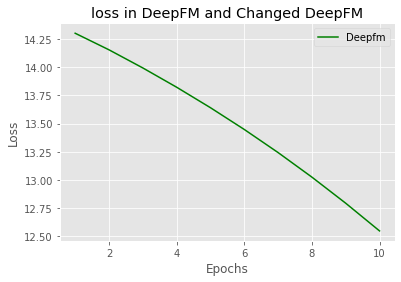

In [ ]:
loss_train = history.history['loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Deepfm')
#plt.plot(epochs, loss_val, 'b', label='Changed DeepFM')
plt.title('loss in DeepFM and Changed DeepFM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def split(x):
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

if __name__ == "__main__":
    data = pd.read_csv("./movielens_sample.txt")
    sparse_features = ["movie_id", "user_id","gender", "age", "occupation", "zip", ]
    target = ['rating']
    for feat in sparse_features:
        lbe = LabelEncoder()
        data[feat] = lbe.fit_transform(data[feat])
    key2index = {}
    genres_list = list(map(split, data['genres'].values))
    genres_length = np.array(list(map(len, genres_list)))
    max_len = max(genres_length)
    genres_list = pad_sequences(genres_list, maxlen=max_len, padding='post', )
    fixlen_feature_columns = [SparseFeat(feat, data[feat].max() + 1,embedding_dim=4) for feat in sparse_features]
    use_weighted_sequence = False
    if use_weighted_sequence:
        varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres',vocabulary_size=len(key2index) + 1,embedding_dim=4), maxlen= max_len, combiner='mean',weight_name='genres_weight')]
    else:
        varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres',vocabulary_size= len(key2index) + 1,embedding_dim=4), maxlen=max_len, combiner='mean',weight_name=None)]
    linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
    dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns
    feature_names = get_feature_names(linear_feature_columns+dnn_feature_columns)
    model_input = {name:data[name] for name in feature_names}
    model_input["genres"] = genres_list
    model_input["genres_weight"] =  np.random.randn(data.shape[0],max_len,1)
    model = DeepFMchanged(linear_feature_columns, dnn_feature_columns,(256, 256),(128, 128,),True, 'relu',0.00001,0.00001,0, 0, 1024,0,'relu', False,'regression')
    model.compile("adam", "mse", metrics=['mse'], )
    history = model.fit(model_input, data[target].values,batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

TypeError: ignored

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

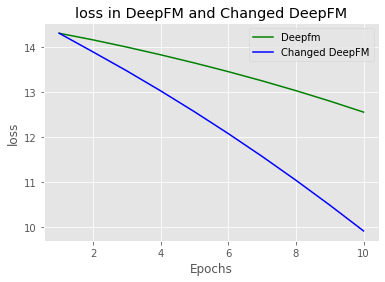

In [ ]:
loss_val = history.history['loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Deepfm')
plt.plot(epochs, loss_val, 'b', label='Changed DeepFM')
plt.title('loss in DeepFM and Changed DeepFM')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()